<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Adversarial_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

With Colab Pro you have priority access to our fastest GPUs. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

train_idx = mnist_train.train_labels <= 1
mnist_train.data = mnist_train.train_data[train_idx]
mnist_train.targets = mnist_train.train_labels[train_idx]

test_idx = mnist_test.test_labels <= 1
mnist_test.data = mnist_test.test_data[test_idx]
mnist_test.targets = mnist_test.test_labels[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [13]:
model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.004185	0.014926	0.000473	0.003199
0.001579	0.005453	0.000473	0.002558
0.001421	0.004402	0.000473	0.002369
0.001026	0.003918	0.000473	0.002250
0.001026	0.003502	0.000946	0.002176
0.000947	0.003136	0.000946	0.002070
0.000869	0.003024	0.000946	0.002018
0.000947	0.002836	0.000473	0.002028
0.000790	0.002708	0.000946	0.001976
0.000711	0.002518	0.000473	0.002011


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Text(0.5, 1.0, 'True Label: 0')

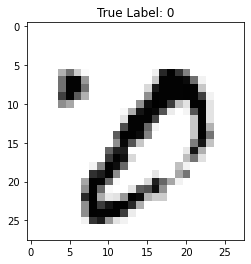

In [15]:
import matplotlib.pyplot as plt
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)
plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
plt.title("True Label: {}".format(y_test[idx].item()))

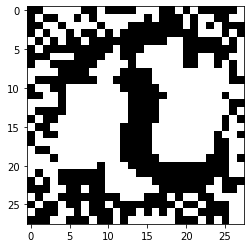

In [16]:
epsilon = 0.2
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

In [17]:
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(0.8534278959810875, 3.281776582659277)


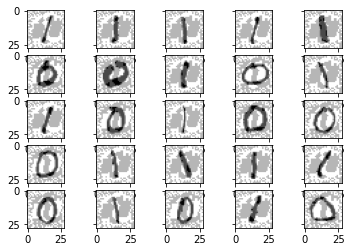

In [20]:
f,ax = plt.subplots(5,5, sharey=True)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

## More memory

With Colab Pro you have the option to access high-memory VMs when they are available. To set your notebook preference to use a high-memory runtime, select the Runtime > 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.

You can see how much memory you have available at any time by running the following code.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). While Colab Pro subscribers still have limits, these will be roughly twice the limits for non-subscribers.

## Resource limits in Colab Pro

Your resources are not unlimited in Colab Pro. To make the most of Colab Pro, please avoid using resources when you don't need them. For example, only use a GPU or high-RAM runtime when required, and close Colab tabs when finished.


## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro and would be interested in a product with higher usage limits, do let us know.

If you encounter errors or other issues with billing (payments) for Colab Pro, please email [colab-billing@google.com](mailto:colab-billing@google.com).